In [ ]:
#@title Reference
#https://medium.com/call-for-atlas/pairs-trading-strategy-every-stock-needs-a-friend-e50723a1dc94

#Libs

In [3]:
#@title Yfinance instalation
!pip install yfinance

In [4]:
#@title Import libs
import pandas as pd
import numpy as np
import yfinance as yf
import os

from statsmodels.tsa.stattools import coint
from itertools import combinations
from statsmodels.tsa.stattools import coint

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

#Functions

In [5]:
#@title Data preparation
def load_ticker_ts_df(ticker, start_date, end_date):
    """
    Load and cache time series financial data from Yahoo Finance API.
    Parameters:
    - ticker (str): The stock ticker symbol (e.g., 'AAPL' for Apple Inc.).
    - start_date (str): The start date in 'YYYY-MM-DD' format for data retrieval.
    - end_date (str): The end date in 'YYYY-MM-DD' format for data retrieval.
    Returns:
    - df (pandas.DataFrame): A DataFrame containing the financial time series data.

    """
    dir_path = './data'
    cached_file_path = f'{dir_path}/{ticker}_{start_date}_{end_date}.pkl'
    try:
        if os.path.exists(cached_file_path):
            df = pd.read_pickle(cached_file_path)
        else:
            df = yf.download(ticker, start=start_date, end=end_date)
            if not os.path.exists(dir_path):
                os.makedirs(dir_path)
            df.to_pickle(cached_file_path)
    except FileNotFoundError:
        print(
            f'Error downloading and caching or loading file with ticker: {ticker}')

    return df


def sanitize_data(data_map):
    TS_DAYS_LENGTH = (pd.to_datetime(END_DATE) -
                      pd.to_datetime(START_DATE)).days
    data_sanitized = {}
    date_range = pd.date_range(start=START_DATE, end=END_DATE, freq='D')
    for ticker, data in data_map.items():
        if data is None or len(data) < (TS_DAYS_LENGTH / 2):
            # We cannot handle shorter TSs
            continue
        if len(data) > TS_DAYS_LENGTH:
            # Normalize to have the same length (TS_DAYS_LENGTH)
            data = data[-TS_DAYS_LENGTH:]
        # Reindex the time series to match the date range and fill in any blanks (Not Numbers)
        data = data.reindex(date_range)
        data['Adj Close'].replace([np.inf, -np.inf], np.nan, inplace=True)
        data['Adj Close'].interpolate(method='linear', inplace=True)
        data['Adj Close'].fillna(method='pad', inplace=True)
        data['Adj Close'].fillna(method='bfill', inplace=True)
        assert not np.any(np.isnan(data['Adj Close'])) and not np.any(
            np.isinf(data['Adj Close']))
        data_sanitized[ticker] = data
    return data_sanitized


def find_cointegrated_pairs(tickers_ts_map, p_value_threshold=0.2):
    """
    Find cointegrated pairs of stocks based on the Augmented Dickey-Fuller (ADF) test.
    Parameters:
    - tickers_ts_map (dict): A dictionary where keys are stock tickers and values are time series data.
    - p_value_threshold (float): The significance level for cointegration testing.
    Returns:
    - pvalue_matrix (numpy.ndarray): A matrix of cointegration p-values between stock pairs.
    - pairs (list): A list of tuples representing cointegrated stock pairs and their p-values.
    """
    tickers = list(tickers_ts_map.keys())
    n = len(tickers)
    # Extract 'Adj Close' prices into a matrix (each column is a time series)
    adj_close_data = np.column_stack(
        [tickers_ts_map[ticker]['Adj Close'].values for ticker in tickers])
    pvalue_matrix = np.ones((n, n))
    # Calculate cointegration p-values for unique pair combinations
    for i, j in combinations(range(n), 2):
        result = coint(adj_close_data[:, i], adj_close_data[:, j])
        pvalue_matrix[i, j] = result[1]
    pairs = [(tickers[i], tickers[j], pvalue_matrix[i, j])
             for i, j in zip(*np.where(pvalue_matrix < p_value_threshold))]
    return pvalue_matrix, pairs

In [6]:
#@title Strategy integration
def calculate_profit(signals, prices):
    """
    Calculate cumulative profit based on trading signals and stock prices.
    Parameters:
    - signals (pandas.DataFrame): A DataFrame containing trading signals (1 for buy, -1 for sell).
    - prices (pandas.Series): A Series containing stock prices corresponding to the signal dates.
    Returns:
    - cum_profit (pandas.Series): A Series containing cumulative profit over time.
    """
    profit = pd.DataFrame(index=prices.index)
    profit['profit'] = 0.0

    buys = signals[signals['orders'] == 1].index
    sells = signals[signals['orders'] == -1].index
    while sells[0] < buys[0]:
        # These are long only strategies, we cannot start with sell
        sells = sells[1:]

    if len(buys) == 0 or len(sells) == 0:
        # no actions taken
        return profit
    if len(sells) < len(buys):
        # Assume we sell at the end
        sells = sells.append(pd.Index(prices.tail(1).index))

    buy_prices = prices.loc[buys]
    sell_prices = prices.loc[sells]

    profit.loc[sells, 'profit'] = sell_prices.values - buy_prices.values
    profit['profit'] = profit['profit'].fillna(0)

    # Make profit cumulative
    profit['cum_profit'] = profit['profit'].cumsum()

    return profit['cum_profit']


def plot_strategy(prices_df, signal_df, profit):
    """
    Plot a trading strategy with buy and sell signals and cumulative profit.
    Parameters:
    - prices (pandas.Series): A Series containing stock prices.
    - signals (pandas.DataFrame): A DataFrame with buy (1) and sell (-1) signals.
    - profit (pandas.Series): A Series containing cumulative profit over time.
    Returns:
    - ax1 (matplotlib.axes.Axes): The top subplot displaying stock prices and signals.
    - ax2 (matplotlib.axes.Axes): The bottom subplot displaying cumulative profit.
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': (3, 1)},
                                   figsize=(18, 12))

    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price in $')
    ax1.plot(prices_df.index, prices_df, color='g', lw=0.25)

    # Plot the Buy and Sell signals
    ax1.plot(signal_df.loc[signal_df.orders == 1.0].index,
             prices_df[signal_df.orders == 1.0],
             '^', markersize=12, color='blue', label='Buy')
    ax1.plot(signal_df.loc[signal_df.orders == -1.0].index,
             prices_df[signal_df.orders == -1.0],
             'v', markersize=12, color='red', label='Sell')

    ax2.plot(profit.index, profit, color='b')
    ax2.set_ylabel('Cumulative Profit (%)')
    ax2.set_xlabel('Date')

    return ax1, ax2


def signals_zscore_evolution(ticker1_ts, ticker2_ts, window_size=15, first_ticker=True):
    """
    Generate trading signals based on z-score analysis of the ratio between two time series.
    Parameters:
    - ticker1_ts (pandas.Series): Time series data for the first security.
    - ticker2_ts (pandas.Series): Time series data for the second security.
    - window_size (int): The window size for calculating z-scores and ratios' statistics.
    - first_ticker (bool): Set to True to use the first ticker as the primary signal source, and False to use the second.Returns:
    - signals_df (pandas.DataFrame): A DataFrame with 'signal' and 'orders' columns containing buy (1) and sell (-1) signals.
    """
    ratios = ticker1_ts / ticker2_ts
    ratios_mean = ratios.rolling(
        window=window_size, min_periods=1, center=False).mean()
    ratios_std = ratios.rolling(
        window=window_size, min_periods=1, center=False).std()
    z_scores = (ratios - ratios_mean) / ratios_std
    buy = ratios.copy()
    sell = ratios.copy()
    if first_ticker:
        # These are empty zones, where there should be no signal
        # the rest is signalled by the ratio.
        buy[z_scores > -1] = 0
        sell[z_scores < 1] = 0
    else:
        buy[z_scores < 1] = 0
        sell[z_scores > -1] = 0
    signals_df = pd.DataFrame(index=ticker1_ts.index)
    signals_df['signal'] = np.where(buy > 0, 1, np.where(sell < 0, -1, 0))
    signals_df['orders'] = signals_df['signal'].diff()
    signals_df.loc[signals_df['orders'] == 0, 'orders'] = None
    return signals_df

#Run

##Data part

In [9]:

#@title Load and prepare the data
crypto_forex_stocks = ['BTC-USD', 'ETH-USD', 'BNB-USD', 'XRP-USD', 'ADA-USD', 'DOGE-USD', 'ETC-USD', 'XLM-USD', 'AAVE-USD', 'EOS-USD', 'XTZ-USD', 'ALGO-USD', 'XMR-USD', 'KCS-USD',
                       'MKR-USD', 'BSV-USD', 'RUNE-USD', 'DASH-USD', 'KAVA-USD', 'ICX-USD', 'LINA-USD', 'WAXP-USD', 'LSK-USD', 'EWT-USD', 'XCN-USD', 'HIVE-USD', 'FTX-USD', 'RVN-USD', 'SXP-USD', 'BTCB-USD', 'BTCB-USD', 'TON-USD', 'SOL-USD']

bank_stocks = ['JPM', 'BAC', 'WFC', 'C', 'GS', 'MS', 'DB', 'UBS', 'BBVA', 'SAN', 'ING', ' BNPQY', 'HSBC', 'SMFG', 'PNC', 'USB', 'BK', 'STT', 'KEY', 'RF', 'HBAN', 'FITB',  'CFG',
               'BLK', 'ALLY', 'MTB', 'NBHC', 'ZION', 'FFIN', 'FHN', 'UBSI', 'WAL', 'SBCF', 'TCBI', 'BOKF', 'PFG', 'GBCI', 'TFC', 'CFR', 'UMBF', 'SPFI', 'FULT', 'ONB', 'INDB', 'IBOC', 'HOMB']

bank_stocks += ["COIN", "RIOT", "MARA", "HUT", "BITF", "SQ", "PYPL", "LC", "SOFI", "UPST", "ARKW", "BLOK", "MSTR", "HOOD", "DKNG", "ICE", "CME", "INTC", "AVGO", "QCOM", "TXN"]

bank_stocks += ["AAPL", "HON", "GE", "CAT", "MMM", "BA", "LMT", "GD", "JNJ", "PFE", "MRK", "ABT", "NVS", "UNH", "PG", "WMT", "KO", "PEP", "XOM", "CVX", "SLB", "COP", "EOG", "OXY", "MPC", "PSX", "VLO", "DOW", "DD", "EMN"]

global_indexes = ['^DJI', '^IXIC', '^GSPC', '^FTSE', '^N225', '^HSI', '^AXJO', '^KS11', '^BFX', '^N100',
                  '^RUT', '^VIX', '^TNX', '^OEX', '^SPX', '^NDX', '^RUI', '^VIX', '^OSX', '^XAU', '^SOX']

START_DATE = '2021-01-01'
END_DATE = '2024-04-20'
universe_tickers = crypto_forex_stocks + bank_stocks + global_indexes
universe_tickers_ts_map = {ticker: load_ticker_ts_df(
    ticker, START_DATE, END_DATE) for ticker in universe_tickers}

# Sample some
uts_sanitized = sanitize_data(universe_tickers_ts_map)
uts_sanitized['JPM'].shape, uts_sanitized['BTC-USD'].shape

((1206, 6), (1206, 6))

<ipython-input-17-6473b450bbce>:72: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  result = coint(adj_close_data[:, i], adj_close_data[:, j])


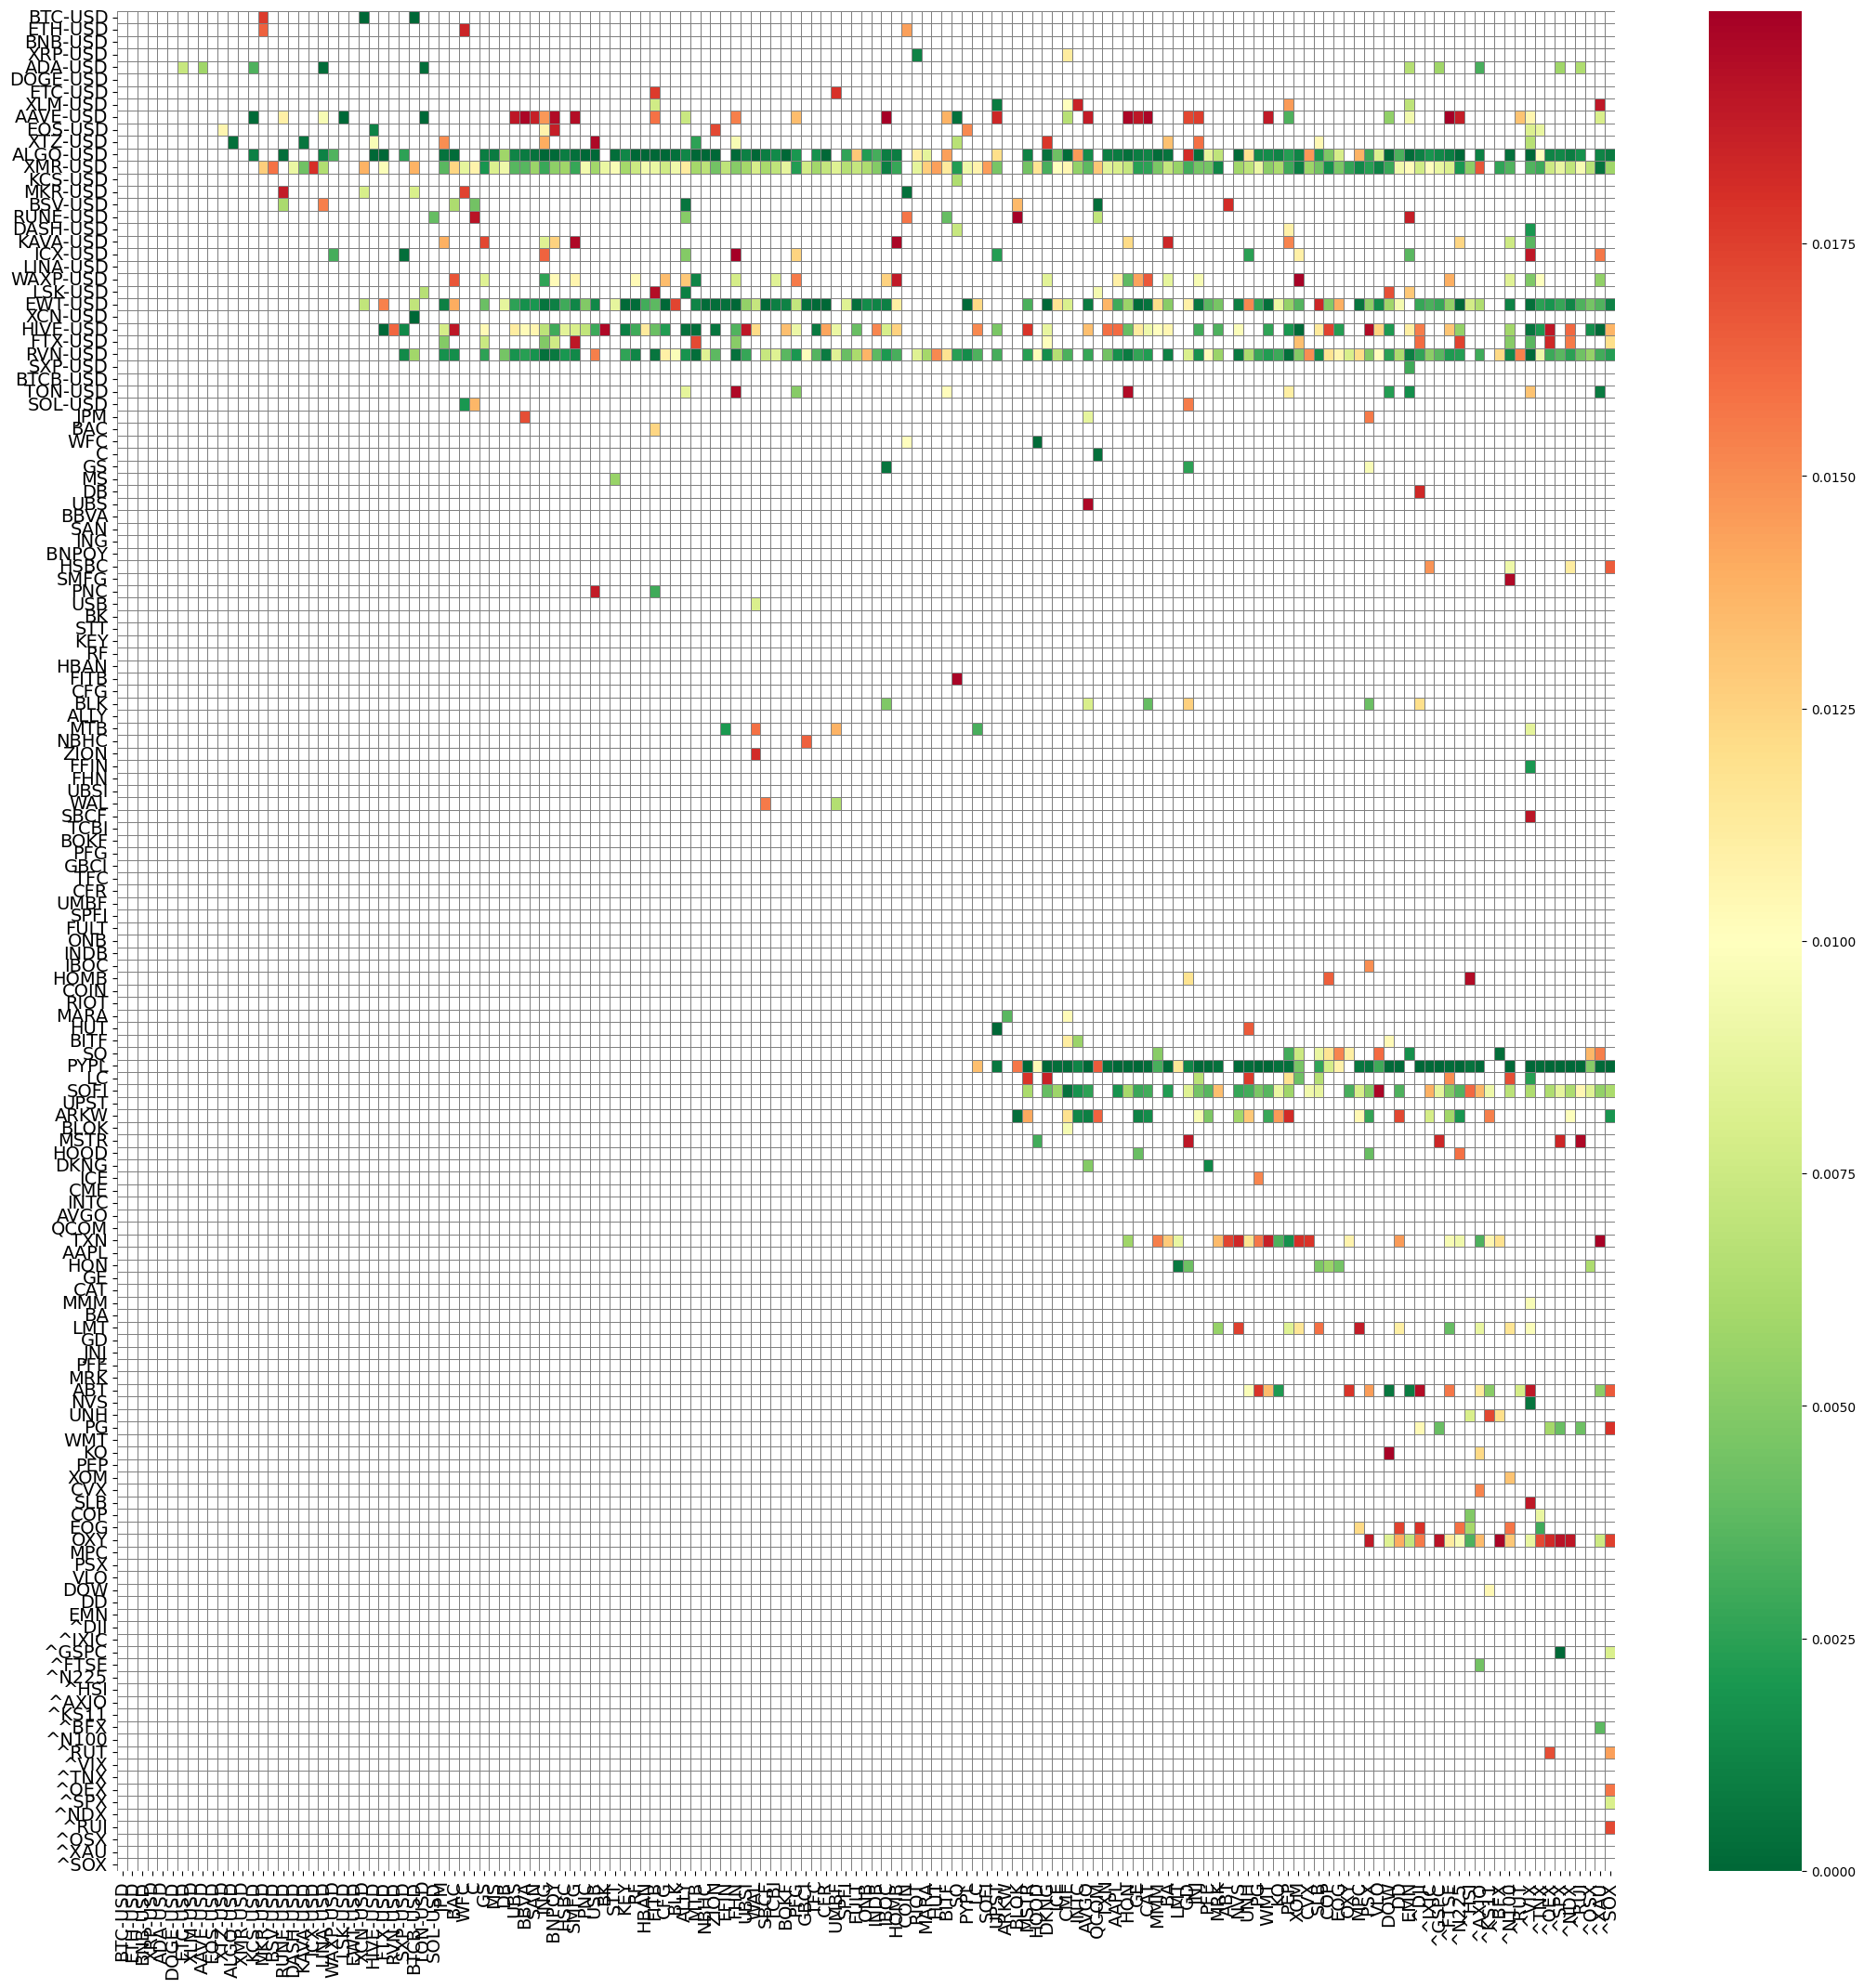

In [ ]:
#@title Get matrix
# This section can take up to 5mins
P_VALUE_THRESHOLD = 0.02
pvalues, pairs = find_cointegrated_pairs(
    uts_sanitized, p_value_threshold=P_VALUE_THRESHOLD)

plt.figure(figsize=(26, 26))
heatmap = sns.heatmap(pvalues, xticklabels=uts_sanitized.keys(),
                      yticklabels=uts_sanitized.keys(), cmap='RdYlGn_r',
                      mask=(pvalues > (P_VALUE_THRESHOLD)),
                      linecolor='gray', linewidths=0.5)
heatmap.set_xticklabels(heatmap.get_xticklabels(), size=14)
heatmap.set_yticklabels(heatmap.get_yticklabels(), size=14)
plt.show()

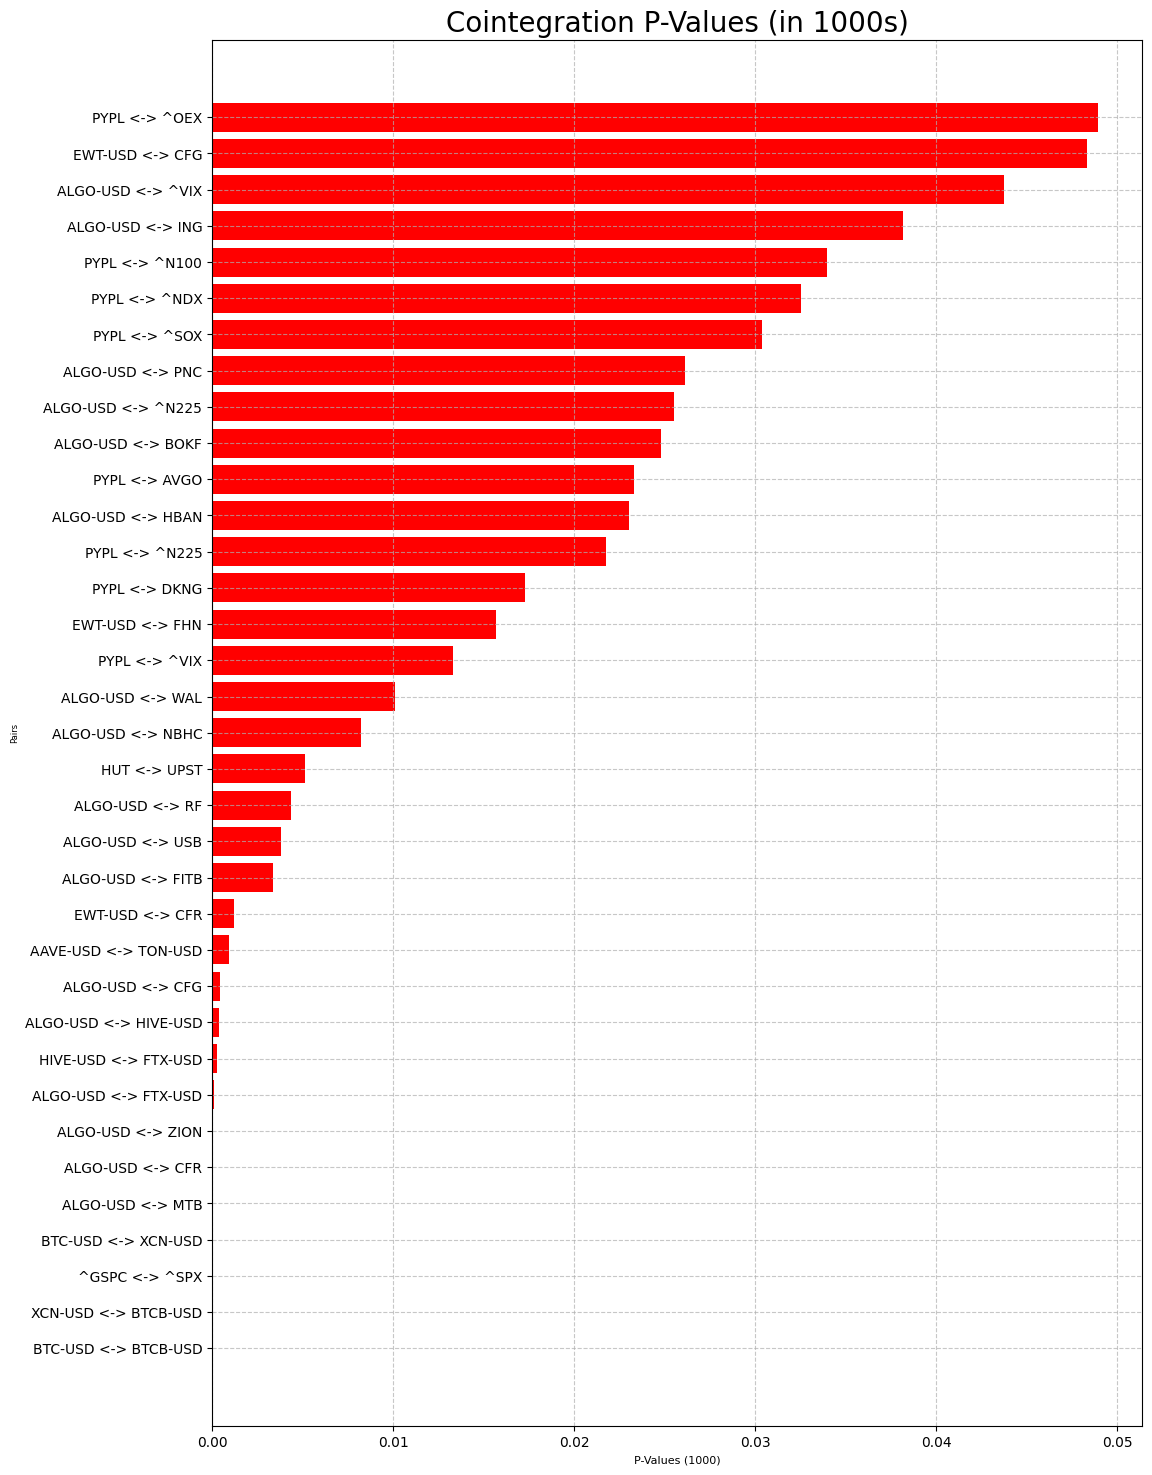

In [ ]:
#@title Get chart
sorted_pairs = sorted(pairs, key=lambda x: x[2], reverse=False)
sorted_pairs = sorted_pairs[0:35]
sorted_pairs_labels, pairs_p_values = zip(
    *[(f'{y1} <-> {y2}', p*1000) for y1, y2, p in sorted_pairs])

plt.figure(figsize=(12, 18))
plt.barh(sorted_pairs_labels,
         pairs_p_values, color='red')
plt.xlabel('P-Values (1000)', fontsize=8)
plt.ylabel('Pairs', fontsize=6)
plt.title('Cointegration P-Values (in 1000s)', fontsize=20)
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()


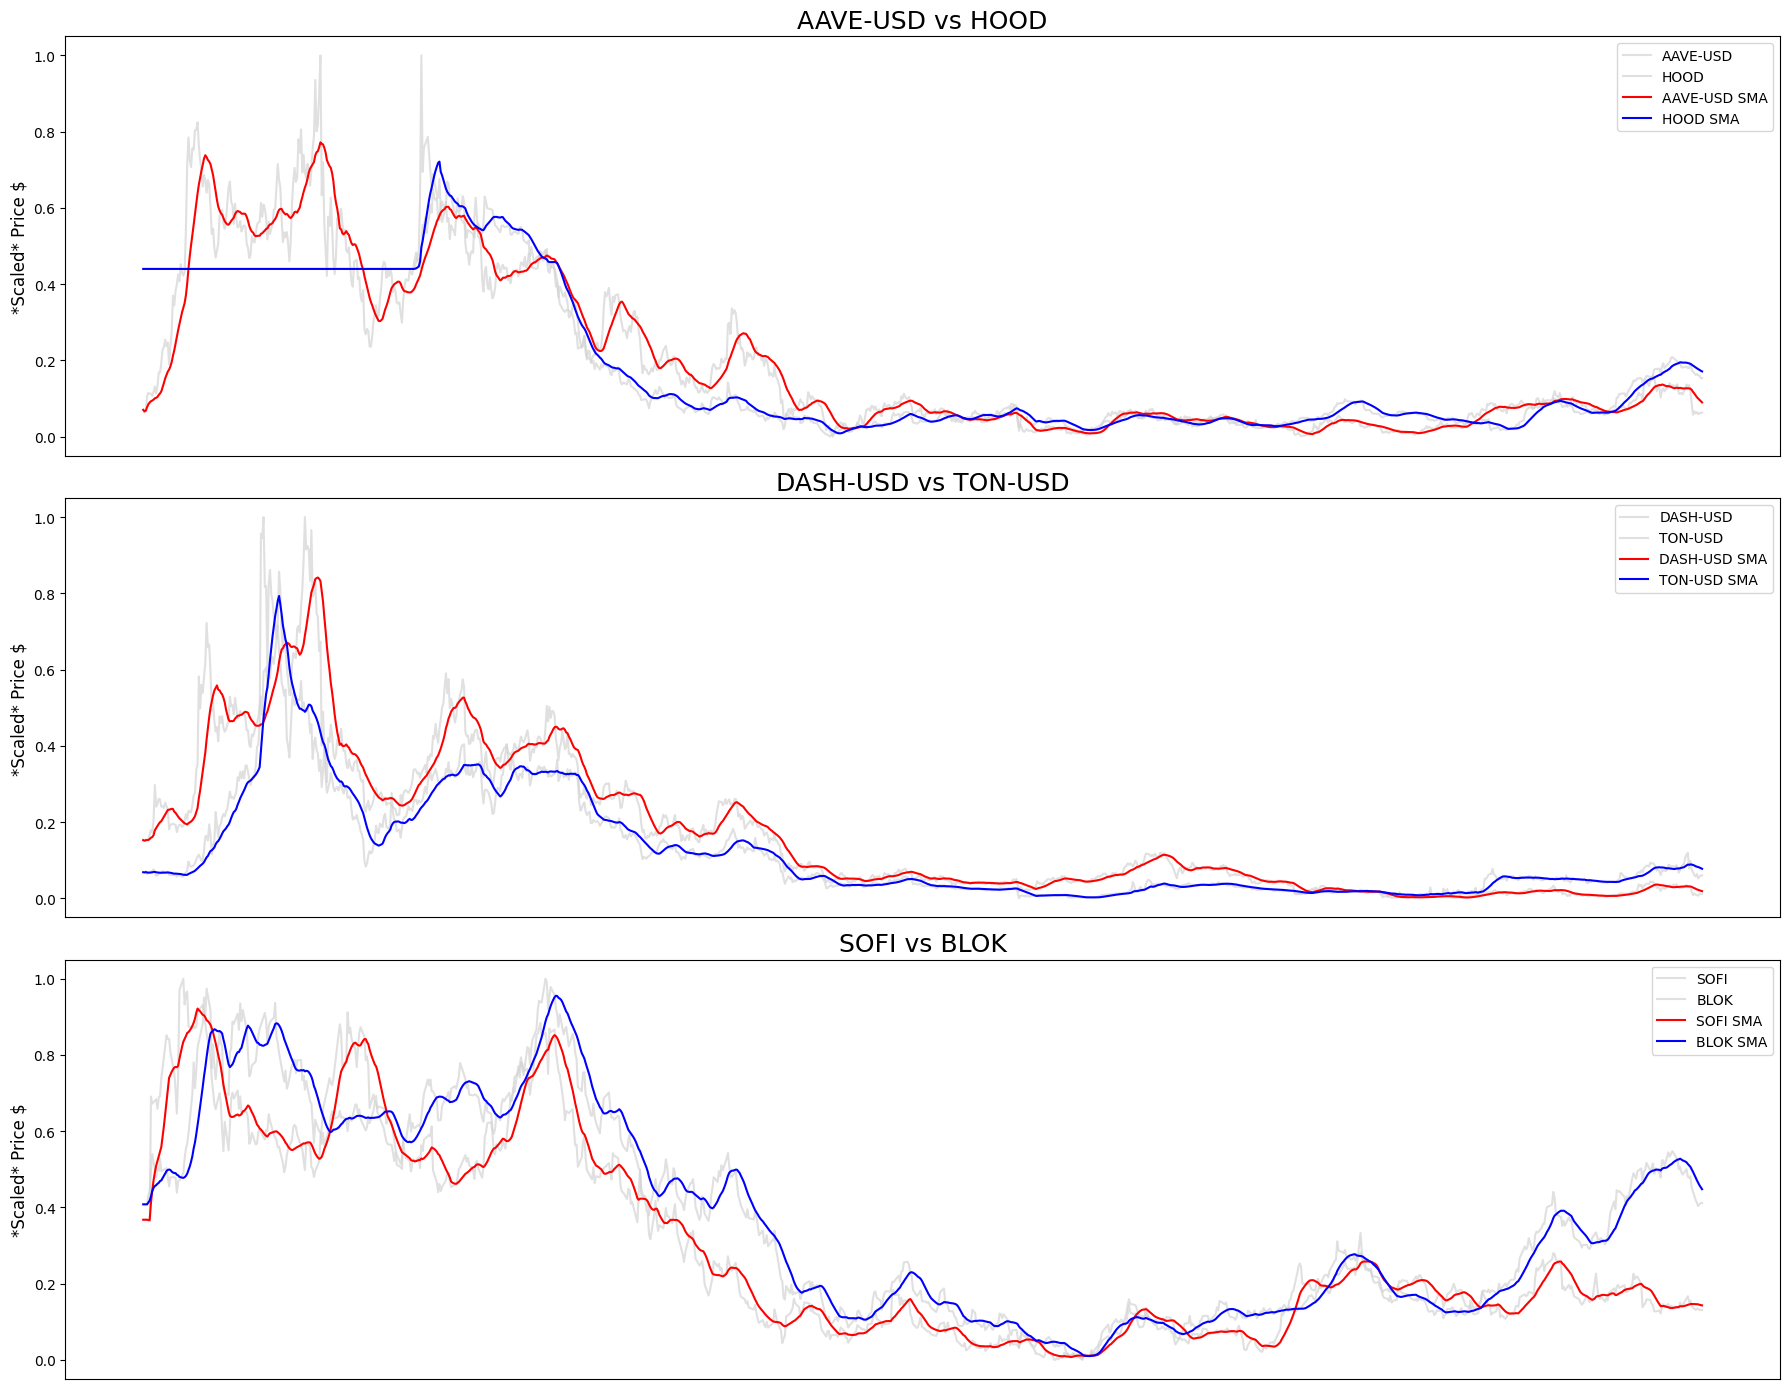

In [ ]:
#@title Look at pairs
ticker_pairs = [("AAVE-USD", "HOOD"), ("DASH-USD", "TON-USD"), ("SOFI", "BLOK")]
fig, axs = plt.subplots(3, 1, figsize=(18, 14))
scaler = MinMaxScaler()
for i, (ticker1, ticker2) in enumerate(ticker_pairs):
    # Scale the price data for each pair using MIN MAX
    scaled_data1 = scaler.fit_transform(
        uts_sanitized[ticker1]['Adj Close'].values.reshape(-1, 1))
    scaled_data2 = scaler.fit_transform(
        uts_sanitized[ticker2]['Adj Close'].values.reshape(-1, 1))
    axs[i].plot(scaled_data1, label=f'{ticker1}', color='lightgray', alpha=0.7)
    axs[i].plot(scaled_data2, label=f'{ticker2}', color='lightgray', alpha=0.7)
    # Apply rolling mean with a window of 15
    scaled_data1_smooth = pd.Series(scaled_data1.flatten()).rolling(
        window=15, min_periods=1).mean()
    scaled_data2_smooth = pd.Series(scaled_data2.flatten()).rolling(
        window=15, min_periods=1).mean()
    axs[i].plot(scaled_data1_smooth, label=f'{ticker1} SMA', color='red')
    axs[i].plot(scaled_data2_smooth, label=f'{ticker2} SMA', color='blue')
    axs[i].set_ylabel('*Scaled* Price $', fontsize=12)
    axs[i].set_title(f'{ticker1} vs {ticker2}', fontsize=18)
    axs[i].legend()
    axs[i].set_xticks([])
plt.tight_layout()
plt.show()

##Strategy part

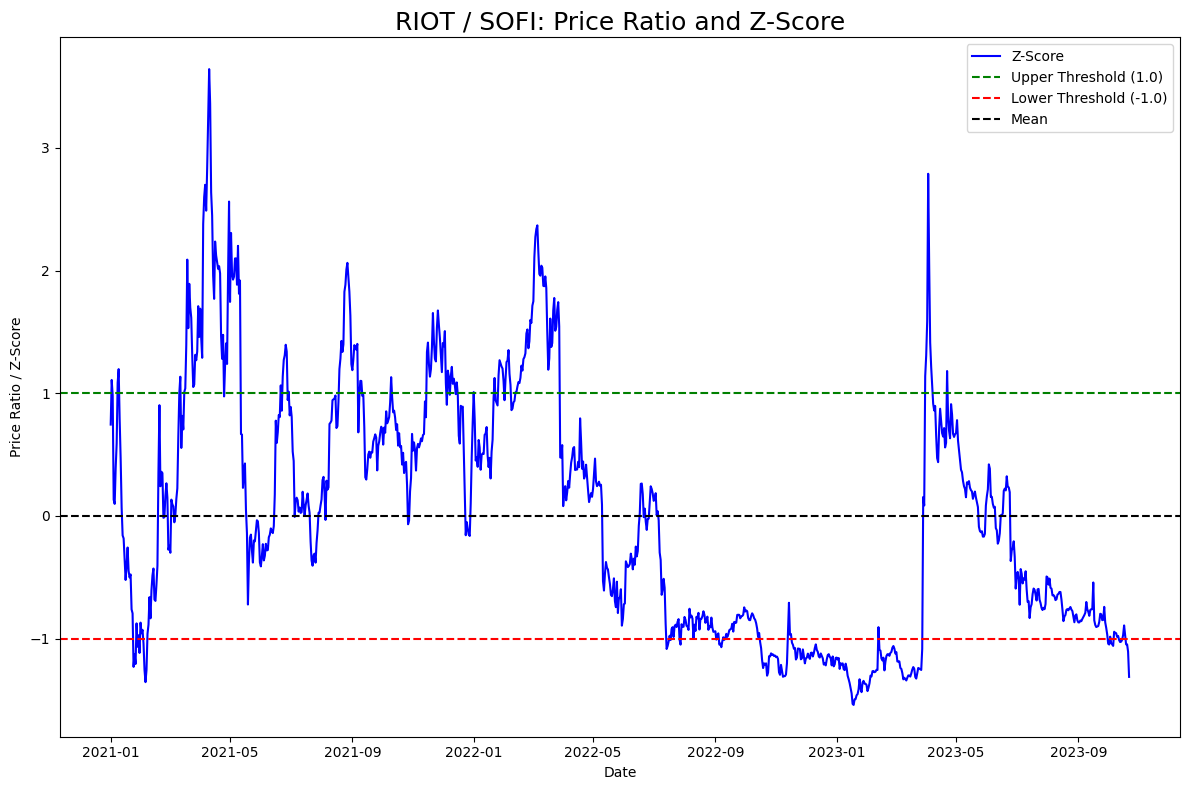

In [ ]:
#@title Split data look at borders
TRAIN = int(len(uts_sanitized["AAVE-USD"]) * 0.85)
TEST = len(uts_sanitized["AAVE-USD"]) - TRAIN

AAVE_ts = uts_sanitized["AAVE-USD"]["Adj Close"][:TRAIN]
C_ts = uts_sanitized["SXP-USD"]["Adj Close"][:TRAIN]
# Calculate price ratio (MKR-USD price / C price)
ratios = C_ts/AAVE_ts
fig, ax = plt.subplots(figsize=(12, 8))
ratios_mean = np.mean(ratios)
ratios_std = np.std(ratios)
ratios_zscore = (ratios - ratios_mean) / ratios_std
ax.plot(ratios.index, ratios_zscore, label="Z-Score", color='blue')
# Plot reference lines
ax.axhline(1.0, color="green", linestyle='--', label="Upper Threshold (1.0)")
ax.axhline(-1.0, color="red", linestyle='--', label="Lower Threshold (-1.0)")
ax.axhline(0, color="black", linestyle='--', label="Mean")
ax.set_title('RIOT / SOFI: Price Ratio and Z-Score', fontsize=18)
ax.set_xlabel('Date')
ax.set_ylabel('Price Ratio / Z-Score')
ax.legend()
plt.tight_layout()
plt.show()

In [22]:
import pandas as pd
import seaborn as sns
from google.colab import files  # Для скачивания файла
import yfinance as yf
import os
import numpy as np
from itertools import combinations
from statsmodels.tsa.stattools import coint

# Ваши функции
def calculate_profit(signals, prices):
    """
    Calculate cumulative profit based on trading signals and stock prices.
    """
    profit = pd.DataFrame(index=prices.index)
    profit['profit'] = 0.0
    buys = signals[signals['orders'] == 1].index
    sells = signals[signals['orders'] == -1].index

    # Проверка на пустые списки
    if len(buys) == 0 or len(sells) == 0:
        return pd.Series(0, index=prices.index)  # Или другой способ обработки

    while sells[0] < buys[0]:
        # These are long only strategies, we cannot start with sell
        sells = sells[1:]
    if len(sells) < len(buys):
        # Assume we sell at the end
        sells = sells.append(pd.Index(prices.tail(1).index))
    buy_prices = prices.loc[buys]
    sell_prices = prices.loc[sells]
    profit.loc[sells, 'profit'] = sell_prices.values - buy_prices.values
    profit['profit'] = profit['profit'].fillna(0)
    # Make profit cumulative
    profit['cum_profit'] = profit['profit'].cumsum()
    return profit['cum_profit']


# Загрузка и подготовка данных
data_map = {}
for ticker in universe_tickers:
    data_map[ticker] = load_ticker_ts_df(ticker, START_DATE, END_DATE)
uts_sanitized = sanitize_data(data_map)
# DataFrame для хранения результатов
results = pd.DataFrame(columns=["Pair1", "Pair2", "Profit"])

# Цикл по всем комбинациям пар
for i in range(len(universe_tickers)):
    for j in range(i + 1, len(universe_tickers)):
        pair1, pair2 = universe_tickers[i], universe_tickers[j]
        # Пропускаем пары с BTCB-USD
        if "BTCB-USD" in (pair1, pair2):
            continue
        # Проверка наличия данных для обеих пар
        if pair1 not in uts_sanitized or pair2 not in uts_sanitized:
            print(f"Данные отсутствуют для пары: {pair1}, {pair2}")
            continue
        # Использование ваших функций
        signals_df1 = signals_zscore_evolution(uts_sanitized[pair1]["Adj Close"], uts_sanitized[pair2]["Adj Close"])
        profit_df1 = calculate_profit(signals_df1, uts_sanitized[pair1]["Adj Close"])
        profit = profit_df1.iloc[-1]  # Получение последнего значения прибыли
        # Исправление: использование pd.concat()
        results = pd.concat([results, pd.DataFrame({"Pair1": [pair1], "Pair2": [pair2], "Profit": [profit]})], ignore_index=True)

# Сортировка и выбор 50 лучших результатов
top_50_results = results.nlargest(50, "Profit")

# Вывод списка пар с доходностью
print(top_50_results[["Pair1", "Pair2", "Profit"]].to_string())


# Сохранение результатов в файл CSV (опционально)
#top_50_results.to_csv("top_50_pairs.csv", index=False)
#files.download("top_50_pairs.csv")

       Pair1   Pair2        Profit
87   BTC-USD    BLOK  71599.225586
76   BTC-USD    COIN  66429.884766
88   BTC-USD    MSTR  65949.671875
47   BTC-USD     STT  59148.632812
86   BTC-USD    ARKW  56677.686523
46   BTC-USD      BK  54796.579102
78   BTC-USD    MARA  54011.988281
39   BTC-USD     SAN  53738.756836
30   BTC-USD     JPM  50325.072266
99   BTC-USD      GE  48484.461914
34   BTC-USD      GS  47299.751953
52   BTC-USD     CFG  45747.391602
53   BTC-USD     BLK  45579.210938
98   BTC-USD     HON  42975.551758
36   BTC-USD      DB  42390.248047
107  BTC-USD     MRK  42303.408203
48   BTC-USD     KEY  41818.580078
51   BTC-USD    FITB  41757.039062
77   BTC-USD    RIOT  41234.550781
124  BTC-USD     DOW  41155.773438
33   BTC-USD       C  40911.898438
68   BTC-USD     CFR  39753.665039
31   BTC-USD     BAC  39684.404297
137  BTC-USD    ^RUT  37880.642578
67   BTC-USD     TFC  37844.841797
57   BTC-USD    ZION  37658.128906
147  BTC-USD    ^SOX  37309.642578
64   BTC-USD    BOKF

<Figure size 2600x1600 with 0 Axes>

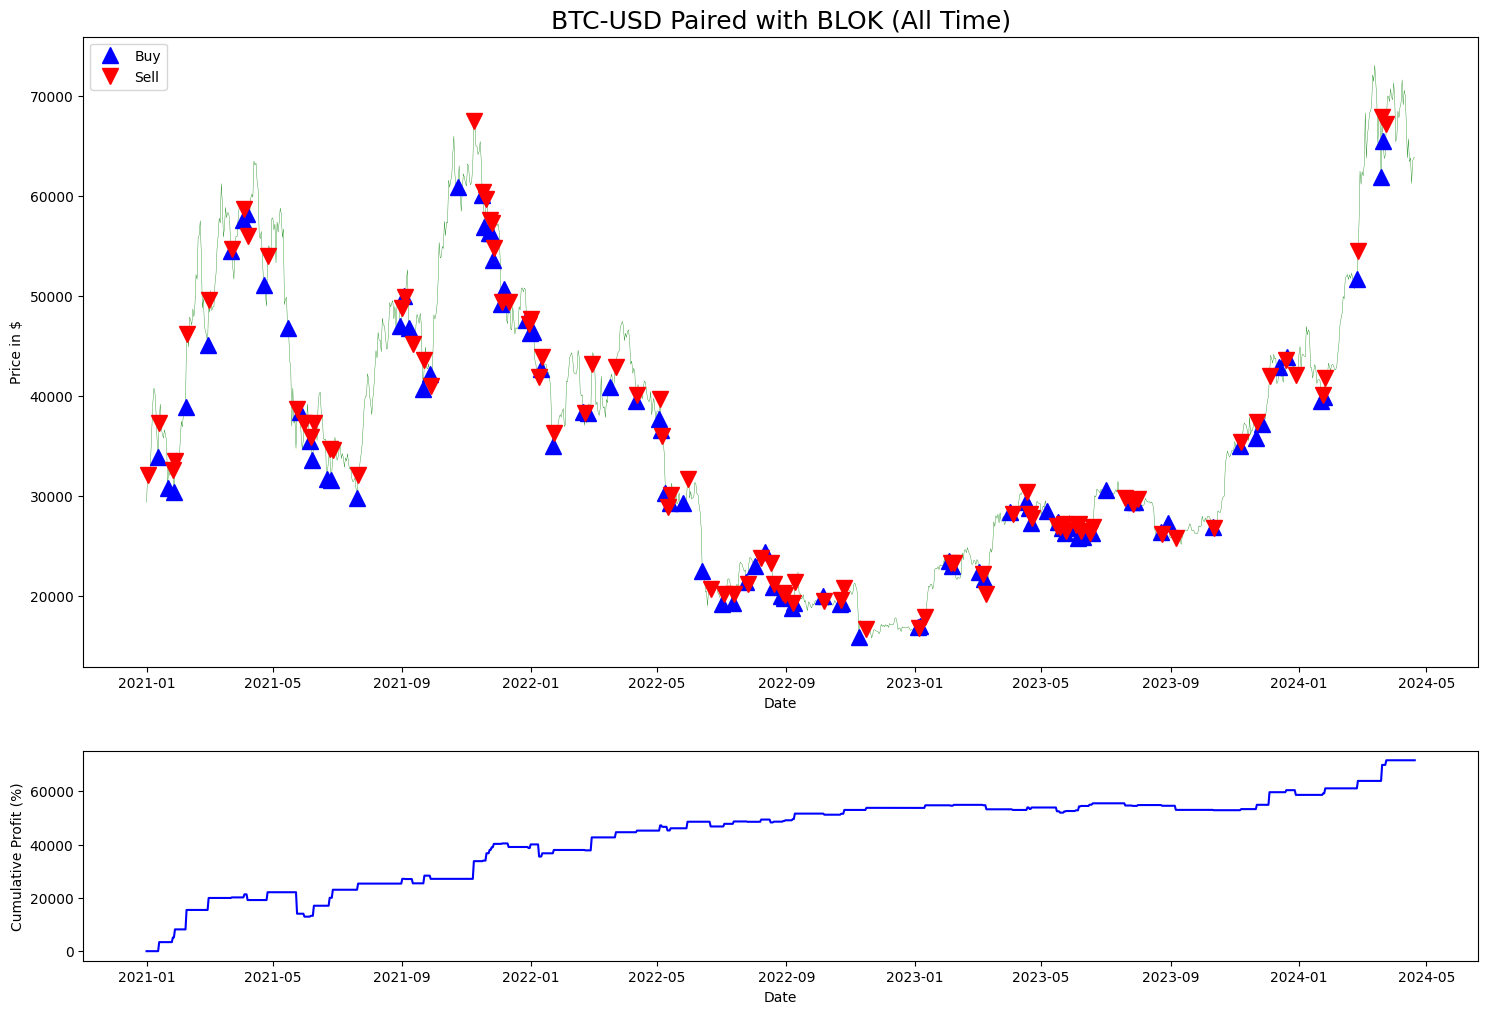

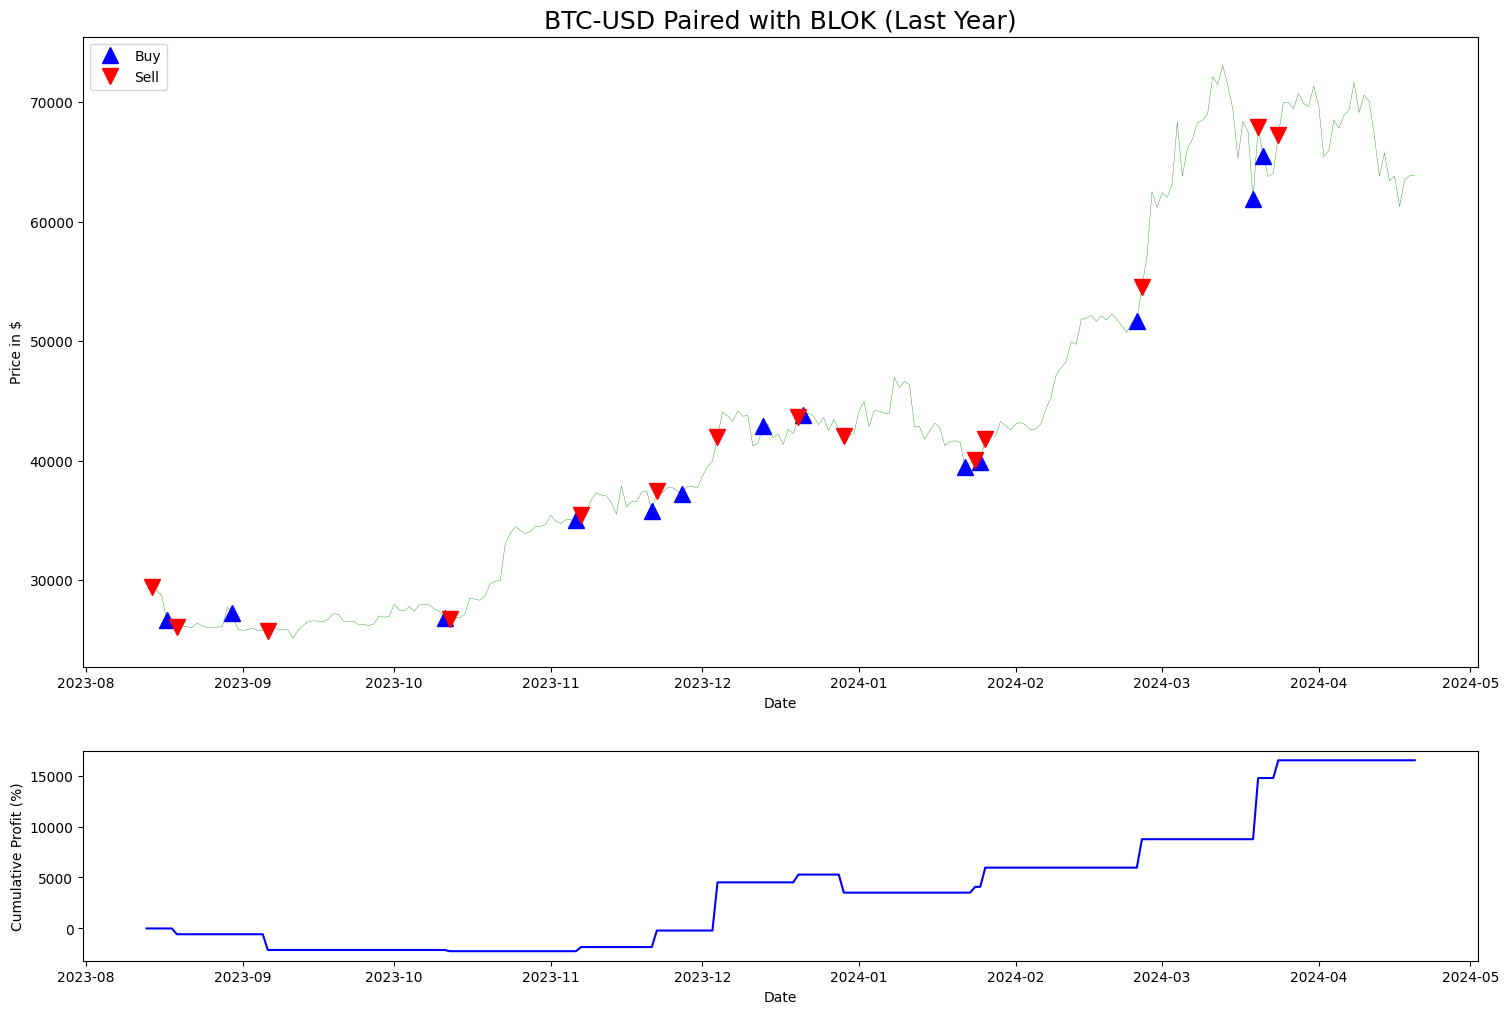

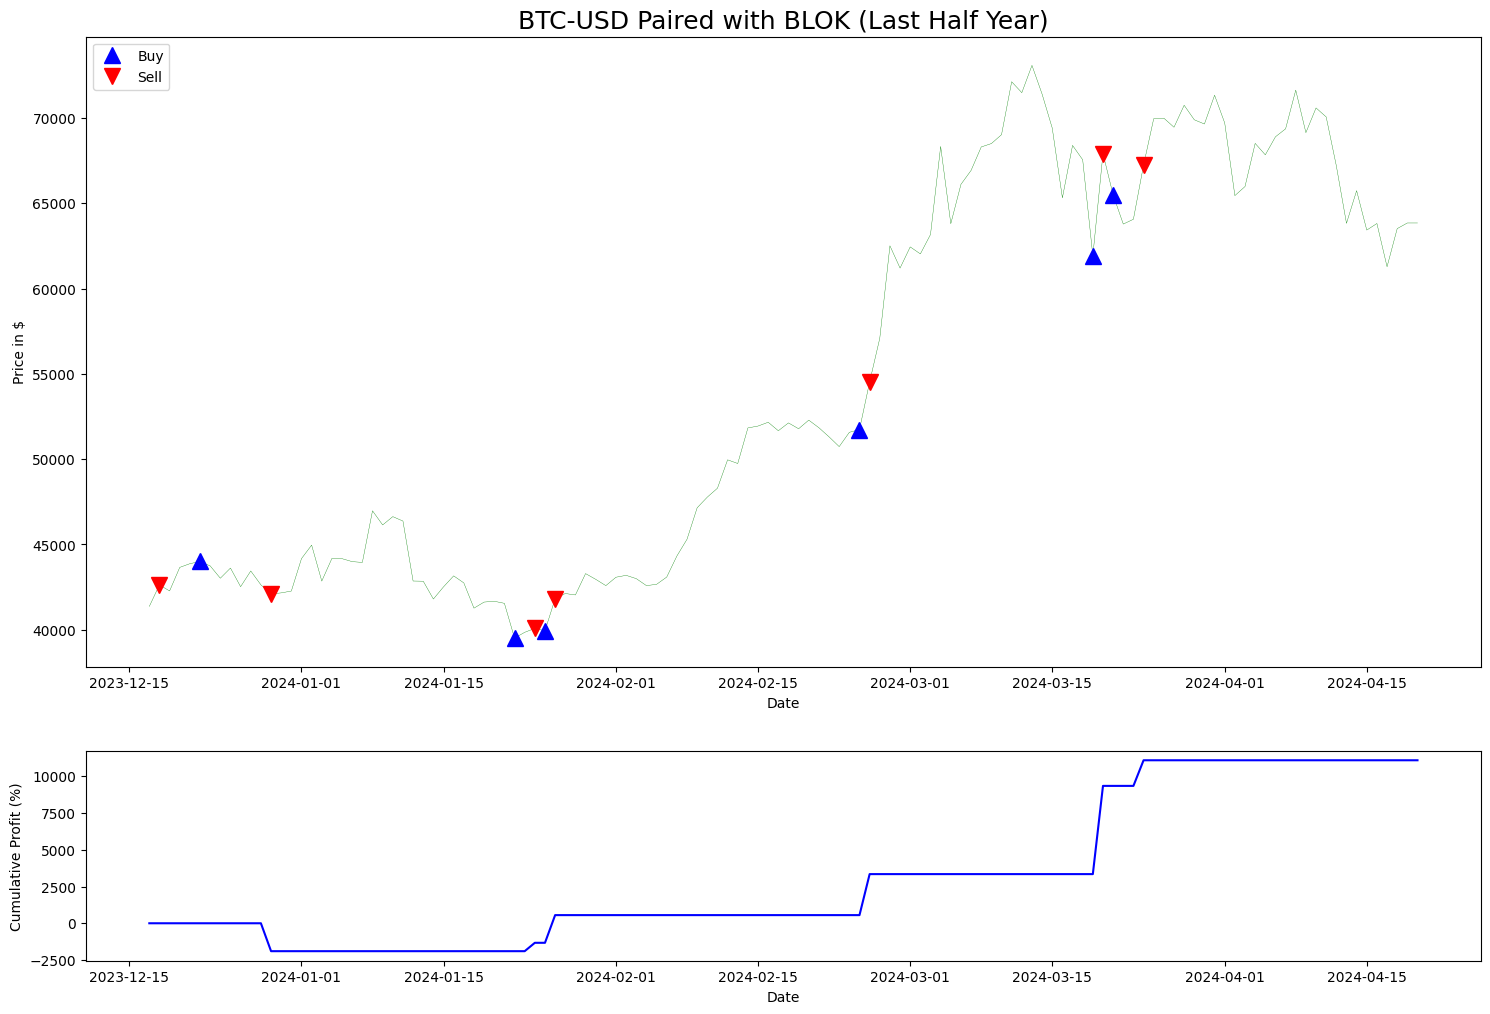

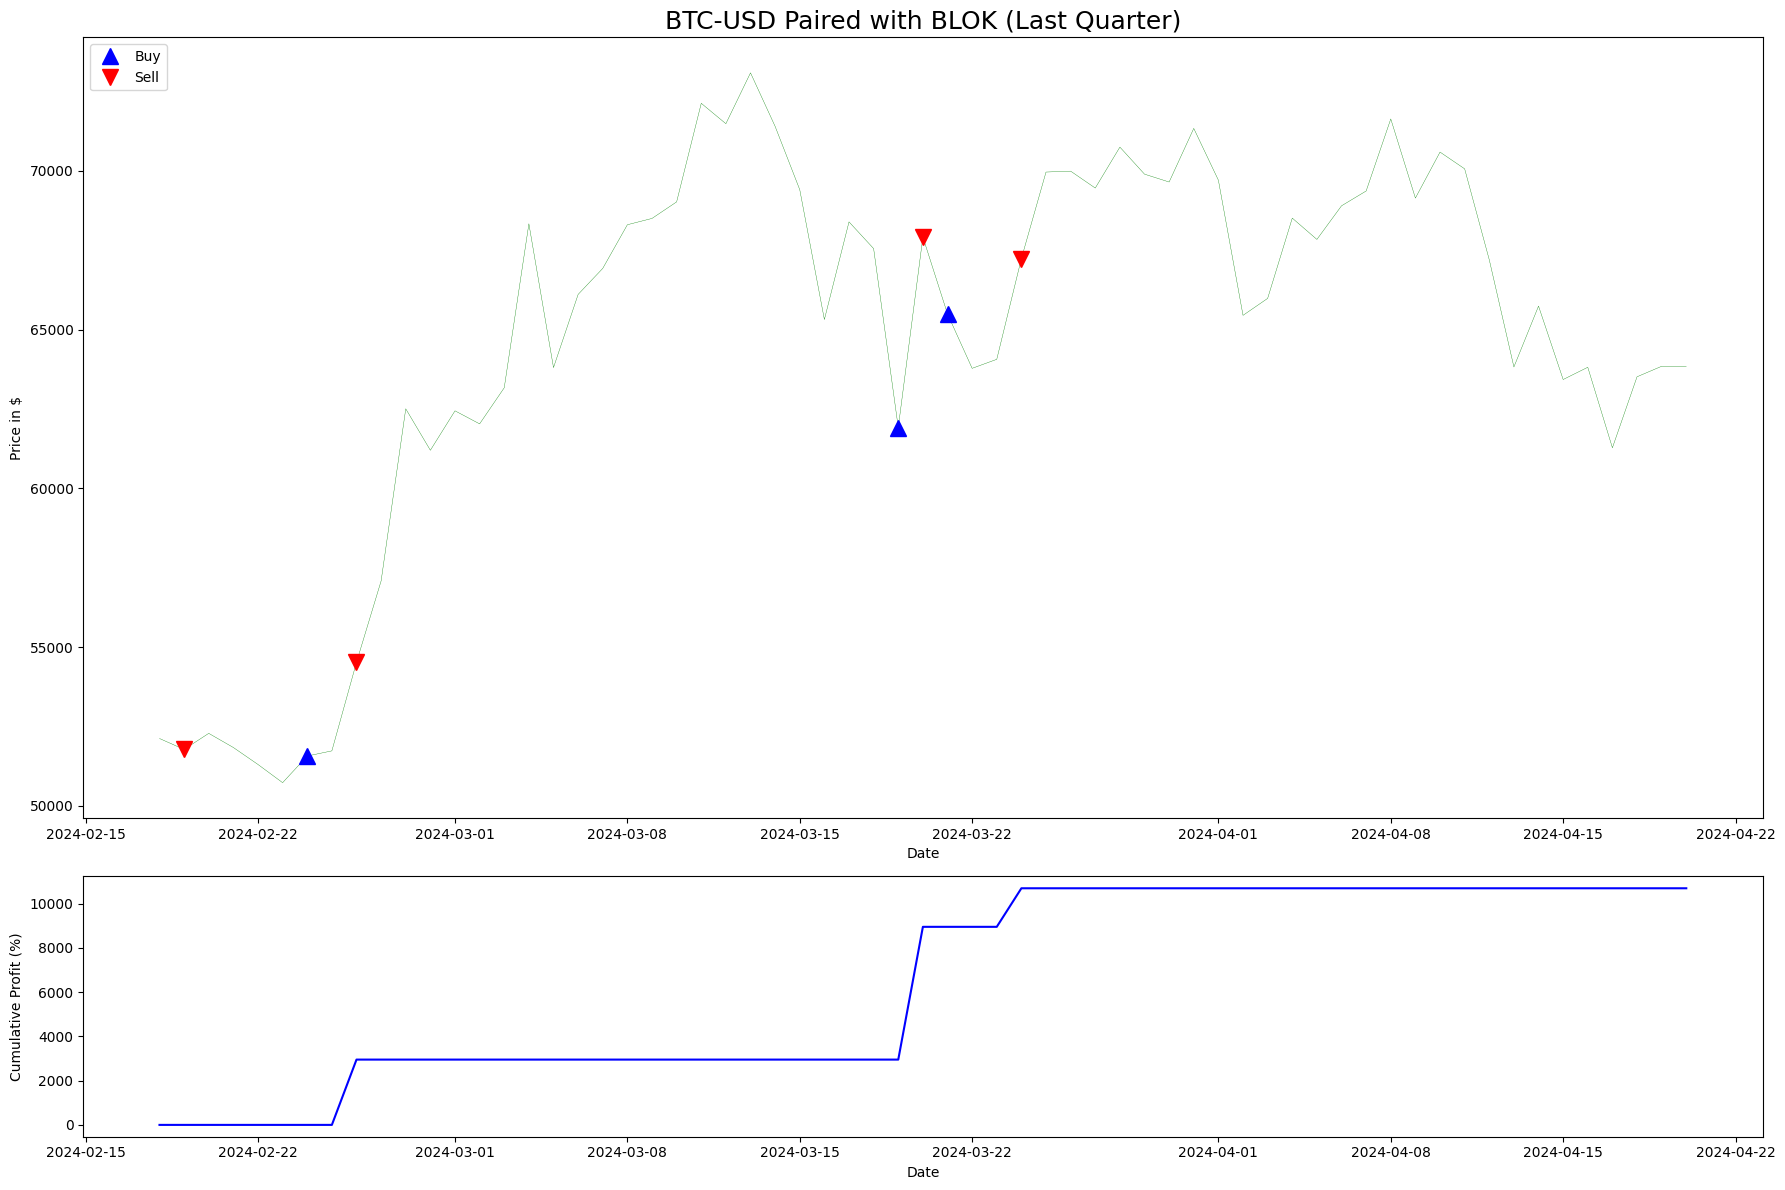

In [33]:
import pandas as pd


AAVE_ts = uts_sanitized["BTC-USD"]["Adj Close"]
C_ts = uts_sanitized["BLOK"]["Adj Close"]


AAVE_tss = ["BTC-USD"] # Переменные для динамического отображения
C_tss = ["BLOK"]


aave_name = C_tss[0] # Костыль чтобы не переписывать код отображения названий
c_name = AAVE_tss[0]

# Функция для создания графика с заданным временным отрезком и заголовком
def plot_with_timerange(ts1, ts2, timerange):
    signals_df = signals_zscore_evolution(ts1[timerange], ts2[timerange])
    profit_df = calculate_profit(signals_df, ts1[timerange])
    ax, _ = plot_strategy(ts1[timerange], signals_df, profit_df)
    ax.set_title(f"{ts2.name} Paired with {ts1.name} ({timerange.start.date()} - {timerange.end.date()})", fontsize=14)
    return ax

plt.figure(figsize=(26, 16))  # Изменен размер для 4 графиков

# График за всё время
signals_df1 = signals_zscore_evolution(AAVE_ts, C_ts)
profit_df1 = calculate_profit(signals_df1, AAVE_ts)
ax1, _ = plot_strategy(AAVE_ts, signals_df1, profit_df1)
ax1.legend(loc='upper left', fontsize=10)
ax1.set_title(f"{c_name} Paired with {aave_name} (All Time)", fontsize=18)

# График за год
last_year = AAVE_ts.index[-252:]
signals_df2 = signals_zscore_evolution(AAVE_ts[last_year], C_ts[last_year])
profit_df2 = calculate_profit(signals_df2, AAVE_ts[last_year])
ax2, _ = plot_strategy(AAVE_ts[last_year], signals_df2, profit_df2)
ax2.legend(loc='upper left', fontsize=10)
ax2.set_title(f"{c_name} Paired with {aave_name} (Last Year)", fontsize=18)

# График за полгода
last_half_year = AAVE_ts.index[-126:]
signals_df3 = signals_zscore_evolution(AAVE_ts[last_half_year], C_ts[last_half_year])
profit_df3 = calculate_profit(signals_df3, AAVE_ts[last_half_year])
ax3, _ = plot_strategy(AAVE_ts[last_half_year], signals_df3, profit_df3)
ax3.legend(loc='upper left', fontsize=10)
ax3.set_title(f"{c_name} Paired with {aave_name} (Last Half Year)", fontsize=18)

# График за квартал
last_quarter = AAVE_ts.index[-63:]
signals_df4 = signals_zscore_evolution(AAVE_ts[last_quarter], C_ts[last_quarter])
profit_df4 = calculate_profit(signals_df4, AAVE_ts[last_quarter])
ax4, _ = plot_strategy(AAVE_ts[last_quarter], signals_df4, profit_df4)
ax4.legend(loc='upper left', fontsize=10)
ax4.set_title(f"{c_name} Paired with {aave_name} (Last Quarter)", fontsize=18)

plt.tight_layout()
plt.show()

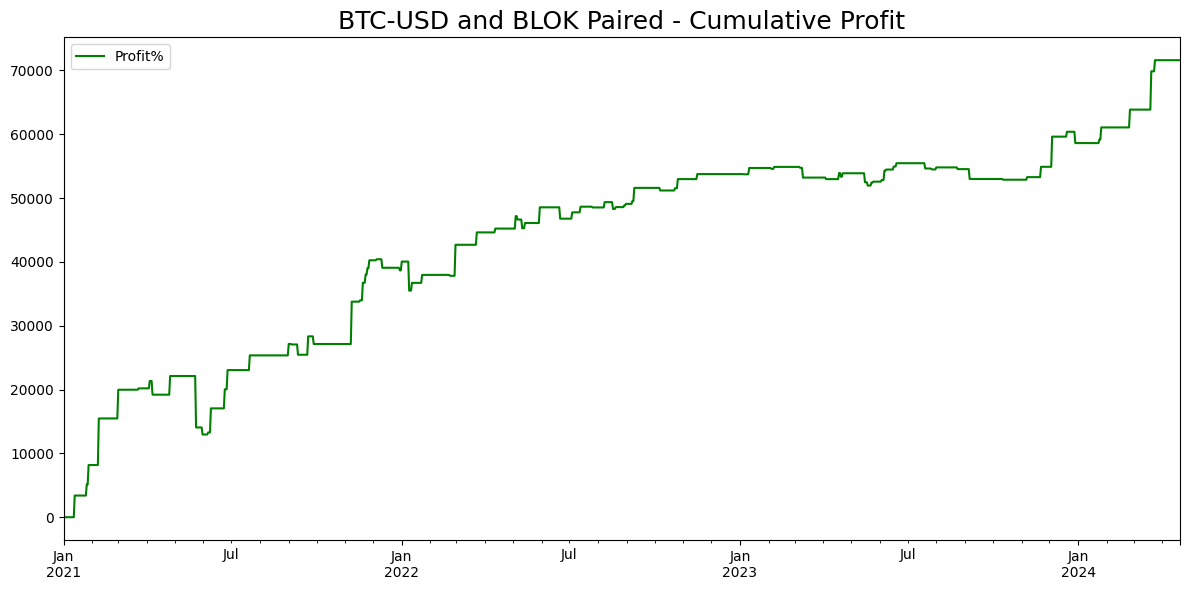

In [34]:
#@title Calculate results
signals_df1 = signals_zscore_evolution(AAVE_ts, C_ts)
profit_df1 = calculate_profit(signals_df1, AAVE_ts)
signals_df2 = signals_zscore_evolution(AAVE_ts, C_ts, first_ticker=False)
profit_df2 = calculate_profit(signals_df2, C_ts)

plt.figure(figsize=(12, 6))
cumulative_profit_combined = profit_df1 + profit_df2
ax2_combined = cumulative_profit_combined.plot(
    label='Profit%', color='green')
plt.legend(loc='upper left', fontsize=10)
plt.title(f'{c_name} and {aave_name} Paired - Cumulative Profit', fontsize=18)
plt.tight_layout()
plt.show()